# Preprocessing Data

In [ ]:
!git clone https://gitlab.com/shimorina/webnlg-dataset.git

Cloning into 'webnlg-dataset'...
remote: Enumerating objects: 5112, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 5112 (delta 2), reused 0 (delta 0), pack-reused 5106 (from 1)
Receiving objects: 100% (5112/5112), 26.09 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (4010/4010), done.


In [ ]:
!git clone https://github.com/WebNLG/webnlg_toolkit.git
%cd webnlg_toolkit
%ls
!pip install -e .

Cloning into 'webnlg_toolkit'...
remote: Enumerating objects: 230, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 230 (delta 45), reused 211 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (230/230), 16.78 MiB | 31.02 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/webnlg_toolkit
LICENSE  README.md  requirements.txt  setup.py  webnlg_toolkit/
Obtaining file:///content/webnlg_toolkit
  Preparing metadata (setup.py) ... done
  Running setup.py develop for webnlg_toolkit


In [ ]:
import os
import glob
import json
import numpy as np
import pandas as pd
import torch
import re
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    AdamW,
    get_linear_schedule_with_warmup
)
!pip install datasets
from datasets import Dataset as HFDataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import webnlg_toolkit
from webnlg_toolkit.utils.data import load_webnlg_dataset
from webnlg_toolkit.utils.data import load_webnlg_xml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 40.7 MB/s eta 0:00:00


In [ ]:
# Define paths
#dataset_root = "/content/drive/MyDrive/en/train/"
#test_root = "/content/drive/MyDrive/en/dev/"

dataset_root = "/content/webnlg-dataset/release_v3.0/en/train/"
test_root = "/content/webnlg-dataset/release_v3.0/en/dev/"

# Function to find dataset files
def find_dataset_files(root_folder, file_extension=".xml"):
    dataset_files = []
    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if file.endswith(file_extension):
                dataset_files.append(os.path.join(subdir, file))
    return dataset_files

# Load training data
def load_all_data(root_folder):
    dataset_files = find_dataset_files(root_folder, file_extension=".xml")
    all_data = []
    for file in dataset_files:
        print(f"Loading: {file}")
        data = load_webnlg_dataset(file, task="rdf2text")
        # print(data)
        all_data.extend(data)
    return all_data

# Load training and test data
train_data = load_all_data(dataset_root)
test_data = load_all_data(test_root)

# Convert to DataFrames
train_df = pd.DataFrame(train_data, columns=["input", "output"])
test_df = pd.DataFrame(test_data, columns=["input", "output"])
print(f"Training examples: {len(train_df)}")
print(f"Test examples: {len(test_df)}")

# Display some examples
print("\nTraining examples:")
print(train_df.head(3))

print("\nTest examples:")
print(test_df.head(3))

Loading: /content/webnlg-dataset/release_v3.0/en/train/7triples/Astronaut.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/7triples/Company.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/7triples/Monument.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/7triples/University.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/3triples/CelestialBody.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/3triples/Airport.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/3triples/Astronaut.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/3triples/Building.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/3triples/Athlete.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/3triples/Food.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/3triples/SportsTeam.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/3triples/WrittenWork.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/3triples/Artis

In [ ]:
def extract_relations(input_text):
    """Extract relation types from input text in the format <S> entity1 <P> relation <O> entity2"""
    relations = []
    pattern = r'<P>\s+(.*?)\s+<O>'
    matches = re.findall(pattern, input_text)
    return matches

# Apply relation extraction to create a new column with relation types
train_df['relations'] = train_df['input'].apply(extract_relations)
test_df['relations'] = test_df['input'].apply(extract_relations)


In [ ]:
def extract_entities(input_text):
    """Extract entity pairs from input text in the format <S> entity1 <P> relation <O> entity2"""
    entity_pairs = []
    pattern = r'<S>\s+(.*?)\s+<P>.*?<O>\s+(.*?)(?:\n|$)'
    matches = re.findall(pattern, input_text)
    return matches

# Apply entity extraction to create a new column with entity pairs
train_df['entity_pairs'] = train_df['input'].apply(extract_entities)
test_df['entity_pairs'] = test_df['input'].apply(extract_entities)


In [ ]:
all_relations = []
for relations in train_df['relations']:
    all_relations.extend(relations)
unique_relations = sorted(list(set(all_relations)))
relation_to_id = {relation: idx for idx, relation in enumerate(unique_relations)}
id_to_relation = {idx: relation for relation, idx in relation_to_id.items()}

print(f"\nNumber of unique relation types: {len(unique_relations)}")
print("Example relation types:", unique_relations[:5])


Number of unique relation types: 372
Example relation types: ['1st runway length feet', '1st runway length metre', '1st runway number', '1st runway surface type', '2nd runway surface type']


In [ ]:
class RelationExtractionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512, relation_to_id=None):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.relation_to_id = relation_to_id

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        input_text = row['input']
        output_text = row['output']

        # For simplicity, we'll use the first relation in each example
        relation = row['relations'][0] if len(row['relations']) > 0 else "unknown"
        entity_pair = row['entity_pairs'][0] if len(row['entity_pairs']) > 0 else ("", "")

        # Create input for BERT: [CLS] entity1 [SEP] entity2 [SEP]
        entity1, entity2 = entity_pair
        encoding = self.tokenizer(
            entity1,
            entity2,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Remove batch dimension
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}

        # Add relation label
        if self.relation_to_id:
            relation_id = self.relation_to_id.get(relation, 0)  # Default to 0 if relation not found
            encoding['labels'] = torch.tensor(relation_id, dtype=torch.long)

        return encoding

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Create datasets
train_dataset = RelationExtractionDataset(train_df, tokenizer, relation_to_id=relation_to_id)
test_dataset = RelationExtractionDataset(test_df, tokenizer, relation_to_id=relation_to_id)

# Split training data into train and validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size],generator=generator1)

print(f"\nTraining set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")



Training set size: 31883
Validation set size: 3543
Test set size: 4464


# Editing Model Parameters

## Dropout Setting & Bias Correction

In [ ]:
# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Set the dropout rate (for both attention and hidden layers)
dropout_rate = 0.1  # Set this to your desired dropout rate (e.g., 0.3)

# Initialize model with modified dropout rates
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(unique_relations),
    hidden_dropout_prob=dropout_rate,        # Dropout rate for hidden layers
    attention_probs_dropout_prob=dropout_rate # Dropout rate for attention layers
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define the betas for bias correction
beta1 = 0.9  # First moment estimate bias correction
beta2 = 0.999  # Second moment estimate bias correction

# Initialize AdamW optimizer with bias correction
optimizer = AdamW(
    model.parameters(),
    lr=1e-5,  # learning rate
    betas=(beta1, beta2),  # Specify betas for bias correction
    eps=1e-8,  # A small value to prevent division by zero
    weight_decay=0.01  # Optional, weight decay for regularization
)

# Set up the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## No Dropout Setting

In [ ]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(unique_relations)
)

# Set up training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Training Model

In [ ]:
# Number of training epochs
num_epochs = 9
total_steps = len(train_loader) * num_epochs

# Create learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

    return total_loss / len(dataloader)

In [ ]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=-1)

            total_loss += loss.item()

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    # Calculate metrics
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return total_loss / len(dataloader), accuracy, f1, all_preds, all_labels

In [ ]:
# Training loop
print("\nStarting training...")
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_loss, val_accuracy, val_f1, _, _ = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)

    print(f"Train loss: {train_loss:.4f}")
    print(f"Validation loss: {val_loss:.4f}")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Validation F1 score: {val_f1:.4f}")


Starting training...

Epoch 1/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 3.0864
Validation loss: 1.6381
Validation accuracy: 0.7392
Validation F1 score: 0.6625

Epoch 2/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 1.3104
Validation loss: 0.9023
Validation accuracy: 0.8597
Validation F1 score: 0.8171

Epoch 3/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.7921
Validation loss: 0.5983
Validation accuracy: 0.8942
Validation F1 score: 0.8654

Epoch 4/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.5439
Validation loss: 0.4443
Validation accuracy: 0.9297
Validation F1 score: 0.9111

Epoch 5/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.4122
Validation loss: 0.3553
Validation accuracy: 0.9407
Validation F1 score: 0.9263

Epoch 6/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.3349
Validation loss: 0.3008
Validation accuracy: 0.9481
Validation F1 score: 0.9354

Epoch 7/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.2869
Validation loss: 0.2705
Validation accuracy: 0.9483
Validation F1 score: 0.9386

Epoch 8/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.2591
Validation loss: 0.2502
Validation accuracy: 0.9551
Validation F1 score: 0.9452

Epoch 9/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.2441
Validation loss: 0.2437
Validation accuracy: 0.9585
Validation F1 score: 0.9496



Model saved to /content/bert_relation_extraction.pt


Text(0.5, 0, 'Epoch')

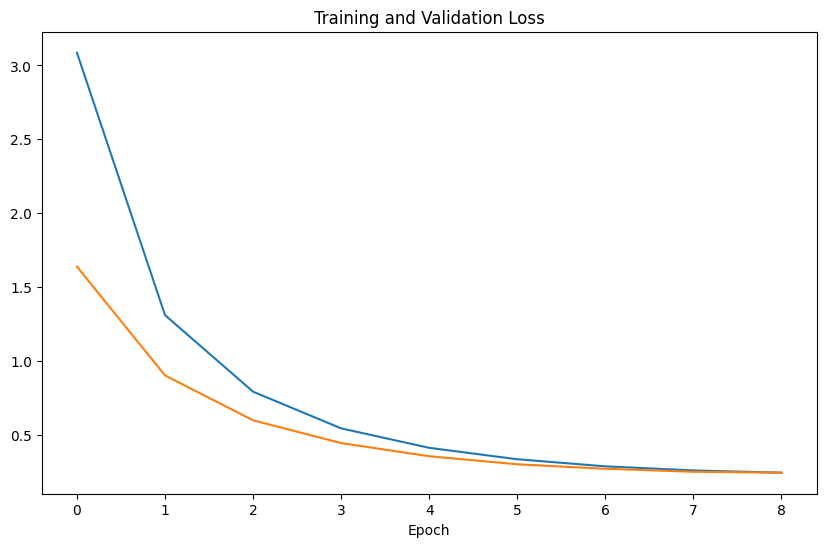

In [ ]:
# Save the model
model_save_path = "/content/bert_relation_extraction.pt"
torch.save(model.state_dict(), model_save_path)
print(f"\nModel saved to {model_save_path}")

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Initialize model with the same architecture
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(unique_relations)
)

# Load the saved weights
model_save_path = "/content/bert_relation_extraction.pt"
model.load_state_dict(torch.load(model_save_path))

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-33a8c6a0dea3>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

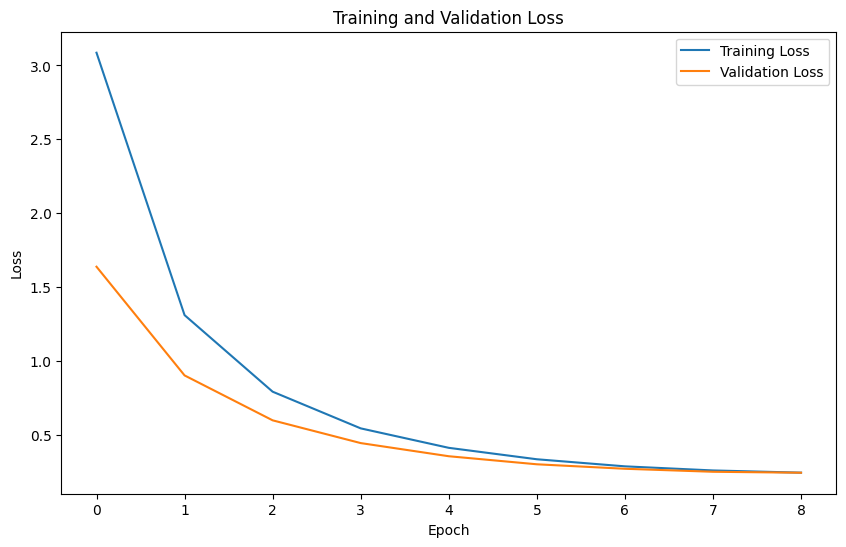

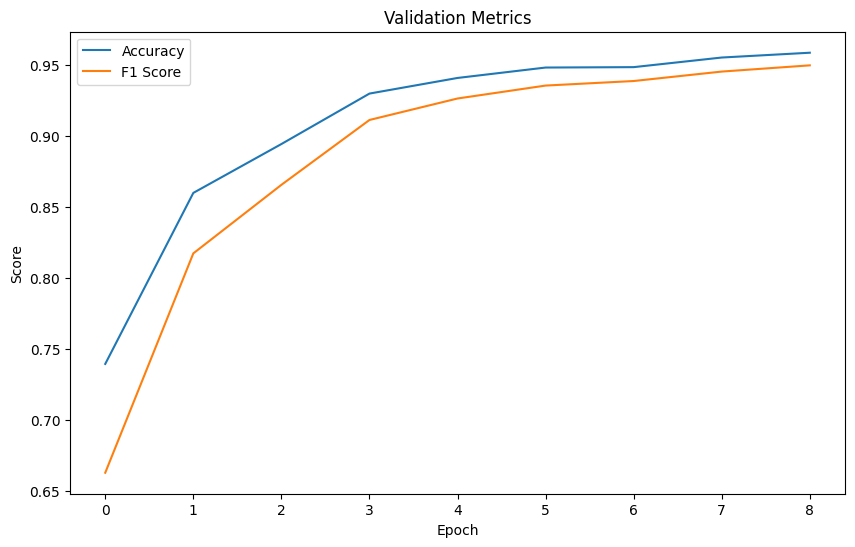

In [ ]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/loss_plot.png')

# Plot validation accuracy and F1 score
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label='Accuracy')
plt.plot(val_f1_scores, label='F1 Score')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
#plt.savefig('/content/drive/MyDrive/metrics_plot.png')


In [ ]:
# Final evaluation on test set
print("\nEvaluating on test set...")
test_loss, test_accuracy, test_f1, test_preds, test_labels = evaluate(model, test_loader, device)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test F1 score: {test_f1:.4f}")


Evaluating on test set...


Evaluating:   0%|          | 0/279 [00:00<?, ?it/s]

Test loss: 0.3997
Test accuracy: 0.9270
Test F1 score: 0.9174


In [ ]:
unique_test_labels = sorted(set(test_labels))  # Extract only present relation IDs
target_names = [id_to_relation[i] for i in unique_test_labels]  # Filter relation names
print(classification_report(test_labels, test_preds, labels=unique_test_labels, target_names=target_names))

                                                   precision    recall  f1-score   support

                          1st runway surface type       0.60      1.00      0.75         3
                          2nd runway surface type       0.00      0.00      0.00         3
                          3rd runway surface type       0.73      1.00      0.84         8
                          4th runway surface type       0.00      0.00      0.00         2
                                     abbreviation       0.80      1.00      0.89        20
                              academic discipline       1.00      0.62      0.76        13
                              academic staff size       1.00      0.82      0.90        17
                            active years end date       1.00      1.00      1.00         1
                          active years start date       1.00      0.43      0.60         7
                          active years start year       0.57      0.67      0.62         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Create a function for real-time inference
def extract_relation(entity1, entity2, text=None):
    """
    Extract relation between two entities using the trained model.

    Args:
        entity1 (str): First entity
        entity2 (str): Second entity
        text (str, optional): Context text containing the entities

    Returns:
        str: Predicted relation type
    """
    # Prepare input for the model
    encoding = tokenizer(
        entity1,
        entity2,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt'
    )

    # Move to device
    encoding = {k: v.to(device) for k, v in encoding.items()}

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()

    # Get relation type
    relation = id_to_relation.get(prediction, "unknown")

    return relation

# Implementing an SVM

In [ ]:
# Method 2: Traditional ML approach (SVM) for comparison
print("\nImplementing Method 2: Traditional ML Approach")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


Implementing Method 2: Traditional ML Approach


In [ ]:
# Create a simplified dataset for SVM
def prepare_data_for_svm(df):
    X = []
    y = []

    for _, row in df.iterrows():
        if len(row['entity_pairs']) > 0 and len(row['relations']) > 0:
            entity1, entity2 = row['entity_pairs'][0]
            relation = row['relations'][0]

            # Create a simple text representation
            text = f"{entity1} {entity2}"

            X.append(text)
            y.append(relation)

    return X, y

In [ ]:
# Prepare data
X_train, y_train = prepare_data_for_svm(train_df)
X_test, y_test = prepare_data_for_svm(test_df)

print(f"SVM training examples: {len(X_train)}")
print(f"SVM test examples: {len(X_test)}")

# Create SVM pipeline
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svm', SVC(kernel='linear', probability=True))
])

SVM training examples: 35426
SVM test examples: 4464


In [ ]:
# Train SVM
print("Training SVM model...")
svm_pipeline.fit(X_train, y_train)

Training SVM model...


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('svm', SVC(kernel='linear', probability=True))])

In [ ]:
# Evaluate SVM
svm_preds = svm_pipeline.predict(X_test)
svm_accuracy = (svm_preds == y_test).mean()
svm_f1 = f1_score(y_test, svm_preds, average='weighted')

print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"SVM F1 Score: {svm_f1:.4f}")


SVM Accuracy: 0.9082
SVM F1 Score: 0.9011


In [ ]:
# Classification report for SVM
print("\nSVM Classification Report:")
print(classification_report(y_test, svm_preds))


SVM Classification Report:
                                                   precision    recall  f1-score   support

                                1st runway number       0.00      0.00      0.00         0
                          1st runway surface type       1.00      1.00      1.00         3
                          2nd runway surface type       0.00      0.00      0.00         3
                          3rd runway surface type       0.73      1.00      0.84         8
                          4th runway surface type       1.00      1.00      1.00         2
                                     abbreviation       0.71      1.00      0.83        20
                              academic discipline       1.00      0.62      0.76        13
                              academic staff size       1.00      0.82      0.90        17
                            active years end date       1.00      1.00      1.00         1
                          active years start date       1.00 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
# Function for SVM real-time inference
def svm_extract_relation(entity1, entity2):
    """
    Extract relation between two entities using the trained SVM model.

    Args:
        entity1 (str): First entity
        entity2 (str): Second entity

    Returns:
        str: Predicted relation type
    """
    # Create input text
    text = f"{entity1} {entity2}"

    # Make prediction
    prediction = svm_pipeline.predict([text])[0]

    return prediction

In [ ]:
# Comparison of both methods
print("\nComparison of BERT and SVM models:")
print(f"BERT Accuracy: {test_accuracy:.4f}")
print(f"BERT F1 Score: {test_f1:.4f}")
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"SVM F1 Score: {svm_f1:.4f}")



Comparison of BERT and SVM models:
BERT Accuracy: 0.9270
BERT F1 Score: 0.9174
SVM Accuracy: 0.9082
SVM F1 Score: 0.9011


In [ ]:
# Example usage
print("\nExample usage:")
entity1 = "AmeriGas"
entity2 = "United States"
bert_relation = extract_relation(entity1, entity2)
svm_relation = svm_extract_relation(entity1, entity2)

print(f"Entities: '{entity1}' and '{entity2}'")
print(f"BERT predicted relation: '{bert_relation}'")
print(f"SVM predicted relation: '{svm_relation}'")



Example usage:
Entities: 'AmeriGas' and 'United States'
BERT predicted relation: 'region served'
SVM predicted relation: 'region served'


In [ ]:
# Demonstrate real-time extraction with a few more examples
test_examples = [
    ("NASA", "Alan Bean"),
    ("Atlas V", "United Launch Alliance"),
    ("ACF Fiorentina", "Italy")
]

print("\nMore examples:")
for entity1, entity2 in test_examples:
    bert_relation = extract_relation(entity1, entity2)
    svm_relation = svm_extract_relation(entity1, entity2)

    print(f"Entities: '{entity1}' and '{entity2}'")
    print(f"BERT predicted relation: '{bert_relation}'")
    print(f"SVM predicted relation: '{svm_relation}'")
    print()


More examples:
Entities: 'NASA' and 'Alan Bean'
BERT predicted relation: 'key person'
SVM predicted relation: 'operator'

Entities: 'Atlas V' and 'United Launch Alliance'
BERT predicted relation: 'manufacturer'
SVM predicted relation: 'manufacturer'

Entities: 'ACF Fiorentina' and 'Italy'
BERT predicted relation: 'ground'
SVM predicted relation: 'full name'



***********************************************************************************************